The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import collections
import time
%matplotlib inline

In [2]:
def read_image(path):
    """All in memory images are RGB images"""
    return mpimg.imread(path)

def to_gray(img):
    if len(img.shape) != 2:
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        return img

def show_image(img, ax=None):
    if ax is None:
        ax = plt
    if len(img.shape) == 2:
        ax.imshow(img, cmap='gray')
    else:
        ax.imshow(img)
def show_images(img_titles):
    """show a list of (img, title), or a list of images"""
    cols = len(img_titles)
    f, axs = plt.subplots(1, cols, figsize=(24, 9))
    f.tight_layout()
    for i, image_title in enumerate(img_titles):
        if type(image_title) is tuple or type(image_title) is list:
            img, title = image_title
        else:
            img = image_title
            title = "unspecified"
        axs[i].set_title(title, fontsize=30)
        show_image(img, axs[i])
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Camera Calibration

In [3]:
class Camera:
    def __init__(self, img_paths):
        """Given chessboard images, calculate camera matrix"""
        objpoints = []
        imgpoints = []
        
        objp = np.zeros((6*9,3), np.float32)
        objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

        img_shape = None
        for f in img_paths:
            img = read_image(f)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
            if ret:
                objpoints.append(objp)
                imgpoints.append(corners)
                img_shape = gray.shape
        
        self.mtx = None
        self.dist = None
        if img_shape:
            ret, self.mtx, self.dist, t1, t2 = cv2.calibrateCamera(objpoints,
                                                                   imgpoints,
                                                                   img_shape, None, None)
    def undistort(self, img):
        "undistort image using calculated camera parameters."
        undist = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
        return undist

In [4]:
images = glob.glob('camera_cal/*.jpg')
camera = Camera(images)

# Correct Image Distortion

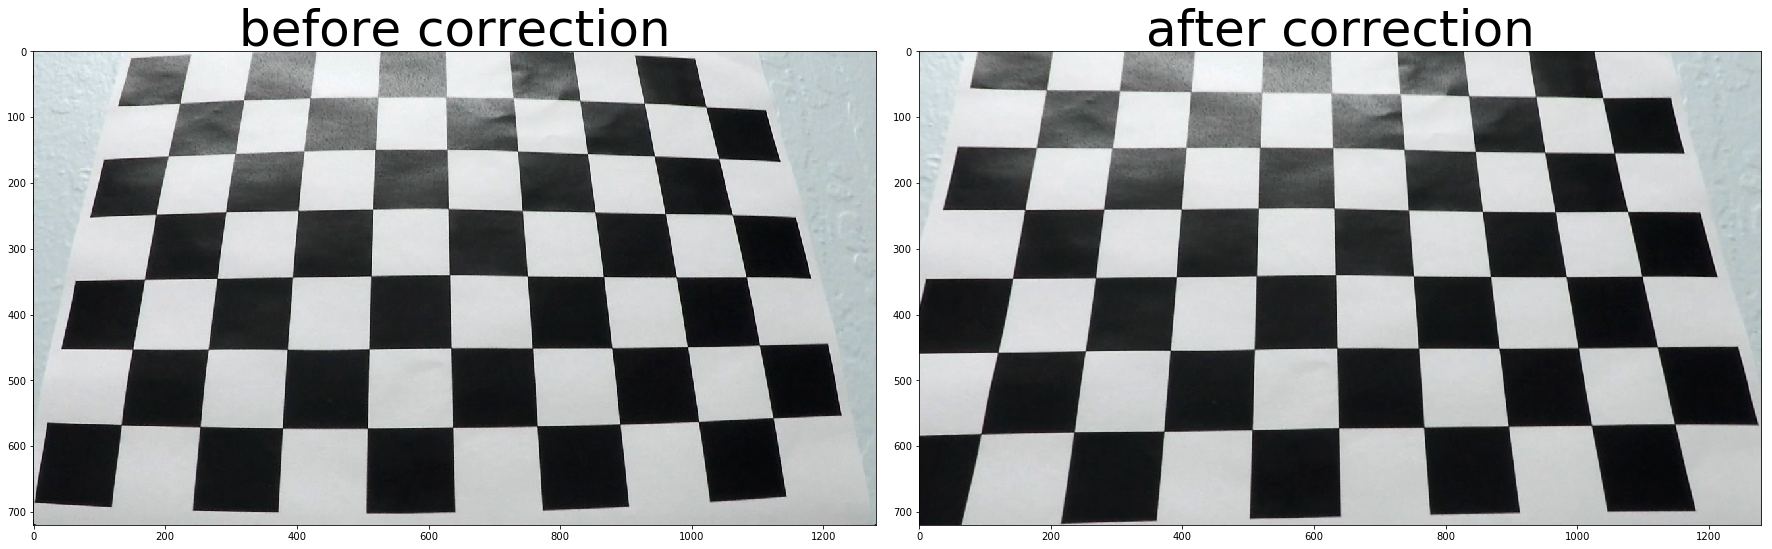

In [5]:
camera_cal = read_image('camera_cal/calibration3.jpg')
calmera_cal_undist = camera.undistort(camera_cal)
show_images([(camera_cal, 'before correction'),
             (calmera_cal_undist, 'after correction')])

In [85]:
# another example
distorted = read_image('test_images/test4.jpg')
distorted_restore = camera.undistort(distorted)
show_images([(distorted, 'distorted'),
            ((distorted_restore, 'undistorted'))])

# Create Thresholded Binary Image

## Color Thresholding

In [6]:
def rgb_to_s_channel(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    return hls[:,:,2]

def color_threshold(img, thresh=(0,255)):
    bc = np.zeros_like(img)
    bc[(img>=thresh[0])&(img<=thresh[1])] = 1
    return bc

## Gradient Thresholding

In [7]:
def mag_threshold(img, sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale when necessary
    gray = to_gray(img)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    g = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(g)/255.0
    g = (g/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(g)
    
    binary_output[(g >= thresh[0]) & (g <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale when necessary
    gray = to_gray(img)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def abs_sobel_threshold(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    
    # Convert to grayscale when necessary
    gray = to_gray(img)

    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        x, y = 1, 0
    else:
        x, y = 0, 1
    
    sobel = cv2.Sobel(gray, cv2.CV_64F, x, y, ksize=sobel_kernel)
    # Take the absolute value of the derivative or gradient
    absx = np.absolute(sobel)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    absx = np.uint8(absx * 255.0/np.max(absx))
    bc = np.zeros_like(absx)
    bc[(absx>thresh[0])&(absx<=thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return bc

def gradient_thresh(img):
    gradx = abs_sobel_threshold(img, orient='x', thresh=(20, 100))
    grady = abs_sobel_threshold(img, orient='y', thresh=(50, 150))
    mag_bin = mag_threshold(img, thresh=(50, 150))
    dir_bin = dir_threshold(img, thresh=(0.7, 1.2))

    comb = np.zeros_like(dir_bin)
    filtering = ((gradx==1)&(grady==1))|((mag_bin==1)&(dir_bin==1))
    comb[filtering] = 1
    return comb

## Combined Color and Gradient Threshold

In [8]:
def combined_thresh(img):
    """Combine thresholds.
    
    Given a RGB image, produce images thresholded by color and gradient"""
    grad_threshed = gradient_thresh(to_gray(img))
    color_threshed = color_threshold(rgb_to_s_channel(img), thresh=(160,254))

    combined_binary = np.zeros_like(color_threshed)
    combined_binary[(color_threshed==1)|(grad_threshed==1)] = 1
    return combined_binary

In [95]:
img = read_image('test_images/problem1.jpg')
threshed = combined_thresh(img)
show_images([(img, "original"),
             (rgb_to_s_channel(img), "s channel"),
             (combined_thresh(img), "threshed")])

# Perspective Transform

In [62]:
class PerspectiveXform(object):
    def __init__(self, width, height):
        marginx = 0
        marginy = 0
        #btm_left, btm_right = [257,679], [1053,679]
        #top_left, top_right = [576,464], [711,464]
        btm_left, btm_right = [0,height], [1280,height]
        top_left, top_right = [550,464], [730,464]
        src = np.float32([top_left, top_right, btm_right, btm_left])
        dst = np.float32([[marginx, marginy], [width-marginx,marginy],
                          [width-marginx,height-marginy],[marginx,height-marginy]])
        self.M = cv2.getPerspectiveTransform(src, dst)
        self.M_inv = cv2.getPerspectiveTransform(dst, src)
    def xform (self, img, inv=False):
        img_size = (img.shape[1], img.shape[0])
        M = self.M if not inv else self.M_inv
        xformed = cv2.warpPerspective(img, M, img_size)
        return xformed

In [63]:
straight_line = read_image("test_images/straight_lines1.jpg")
undist = camera.undistort(straight_line)
xform = PerspectiveXform(undist.shape[1], undist.shape[0])
pxform_img = xform.xform(undist)
show_images([(straight_line, 'original'),
             (undist, 'undistorted'),
             (pxform_img, 'xformed')])

# Finding the Lanes and Fit a Polynomial

In [71]:
class FitLines(object):
    def __init__(self):
        self.ym_per_pix = 30.0/720 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/700 # meters per pixel in x dimension

    def __fit (self, binary_warped, debug=False):
        # Take a histogram of the bottom half of the image
        height = int(binary_warped.shape[0]/2)
        histogram = np.sum(binary_warped[height:,:], axis=0)
        if debug:
            plt.bar(np.arange(len(histogram)), histogram)
            return None
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        return left_fit, right_fit
    def fix_distance(self, ploty, leftx, rightx, ymax):
        ym_per_pix = self.ym_per_pix
        xm_per_pix = self.xm_per_pix

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new R of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*ymax*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*ymax*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

        return (left_curverad, right_curverad)

    def vis (self, binary_warped, prev_left_fit=None, prev_right_fit=None):
        """Return
        an image with a Polynomial lines inner area filled,
        curvature (left,right) tuple,
        length of vehicle derivation from center.
        """
        left_fit, right_fit = self.__fit(binary_warped)
        if prev_left_fit != None:
            # Check whether this left_fit and right_fit is outlier.
            # Average fit
            prev_left_fit.append(left_fit)
            prev_right_fit.append(right_fit)
            # update current_fit
            left_fit = np.average(np.array(prev_left_fit), axis=0)
            right_fit = np.average(np.array(prev_right_fit), axis=0)
            
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        # curvature
        curv = self.fix_distance(ploty, left_fitx, right_fitx, binary_warped.shape[0])
        # vehicle position from center. fit the line using ymax
        ymax = binary_warped.shape[0]
        xmax = binary_warped.shape[1]
        x_left = left_fit[0]*ymax**2 + left_fit[1]*ymax + left_fit[2]
        x_right = right_fit[0]*ymax**2 + right_fit[1]*ymax + right_fit[2]
        from_center = (((x_left+x_right)/2)-xmax/2) * self.xm_per_pix

        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))
        
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))
        return color_warp, curv, from_center

# All together: Annotate Images

In [86]:
class AnnotateLane(object):
    def __init__(self, camera, for_video=False):
        """
        @param camera calibrated camera
        """
        self.camera = camera
        self.fitlines = FitLines()
        self.xform = PerspectiveXform(1280, 720)
        # history data
        self.left_fit = collections.deque(maxlen=10) if for_video else None
        self.right_fit = collections.deque(maxlen=10) if for_video else None

    def annotate_image(self, img, debug=False):
        """Given an image, return an annotated image."""
        undist = camera.undistort(img)
        # threshold image
        threshed = combined_thresh(undist)
        # perspective transform
        xformed = self.xform.xform(threshed)
        # fit lines, find area to annotate
        area, (left_curv, right_curv), from_center = \
            self.fitlines.vis (xformed, 
                               prev_left_fit=self.left_fit,
                               prev_right_fit=self.right_fit)
        # inverse perspective xform
        inv_area = self.xform.xform(area, inv=True)
        # annotate areas on original images        
        ann = cv2.addWeighted(undist, 1, inv_area, 0.3, 0)
        # annotate curvature
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_color=(255,255,255)
        cv2.putText(ann, "curvature: left %.2f m, right %.2f m"%(left_curv,right_curv),
                    (50, 50), font, 1.0, font_color, 2)
        cv2.putText(ann, "deviation from center: %.2f m"% from_center,
                    (50, 80), font, 1.0, font_color, 2)
        if debug:
            show_images([(undist, 'undist'), (threshed, 'threshed'),
                         (xformed, 'xformed'), (area, 'area'),
                         (inv_area, 'inv_area'), (ann, 'annotated')])
        return ann
    def annotate_and_show(self, file):
        img = read_image(file)
        annotated = self.annotate_image(img)
        show_image(annotated)

In [87]:
camera_cals = glob.glob('camera_cal/*.jpg')
camera = Camera(camera_cals)
annot = AnnotateLane (camera)

In [88]:
image_files = ['straight_lines1.jpg', 'straight_lines2.jpg',
               'test1.jpg', 'test2.jpg', 'test3.jpg',
               'test4.jpg', 'test5.jpg', 'test6.jpg']
images = [read_image('test_images/'+i) for i in image_files]

#image_files = ['image%s.jpg'%i for i in range(1, 7)]
#images = [read_image(i) for i in image_files]
annotated_image = [annot.annotate_image(i) for i in images]
annotated_image_titles = list(zip(annotated_image, image_files))

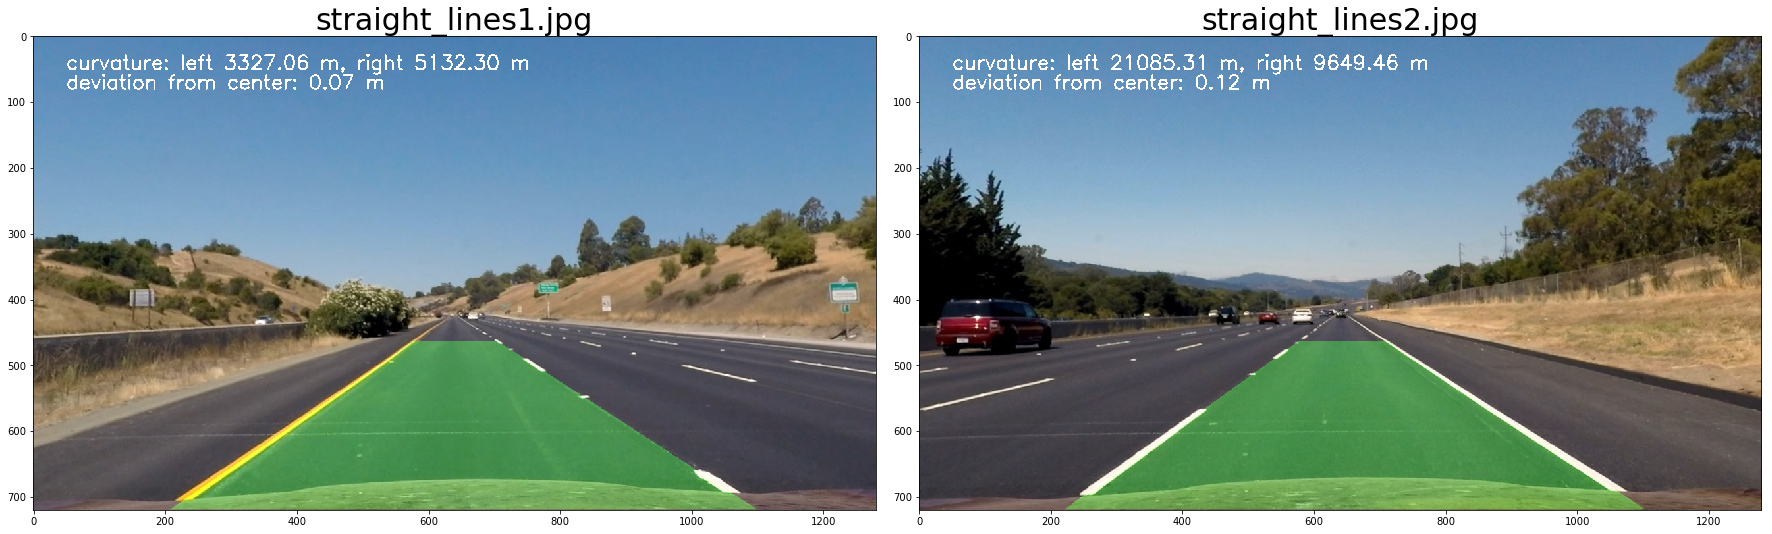

In [89]:
show_images(annotated_image_titles[:2])

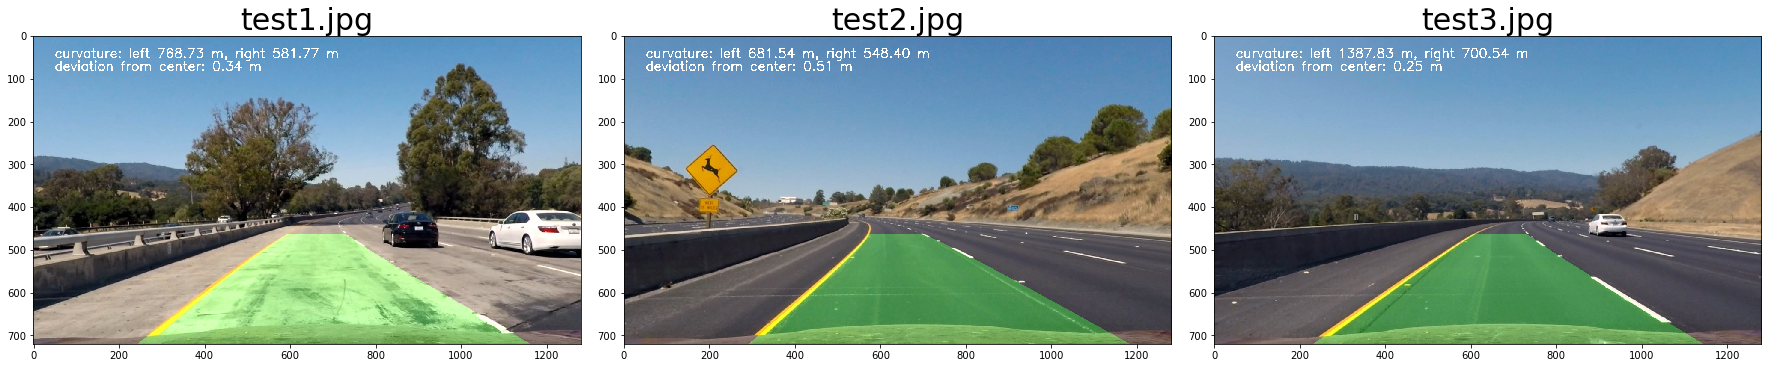

In [90]:
show_images(annotated_image_titles[2:5])

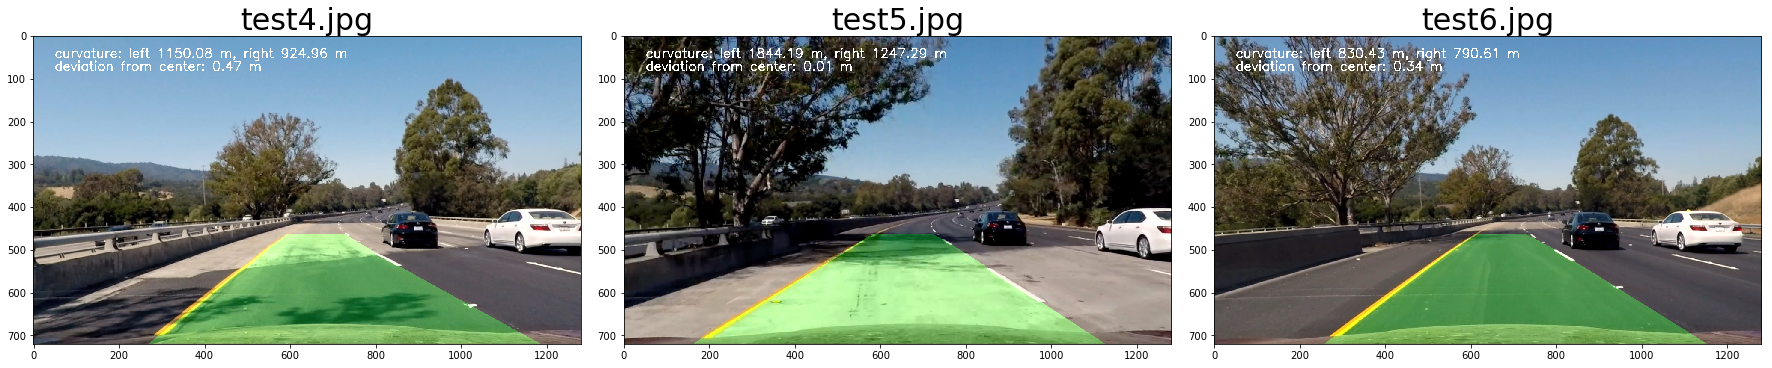

In [91]:
show_images(annotated_image_titles[5:])

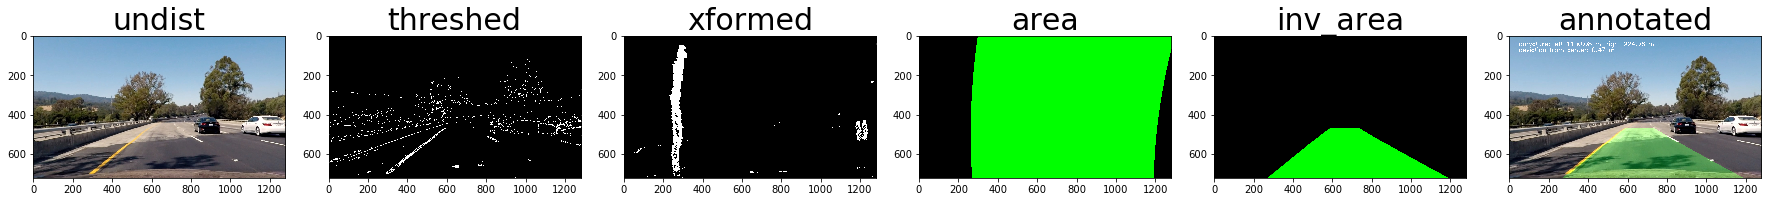

In [92]:
_ = annot.annotate_image(read_image('test_images/test4.jpg'), debug=True)

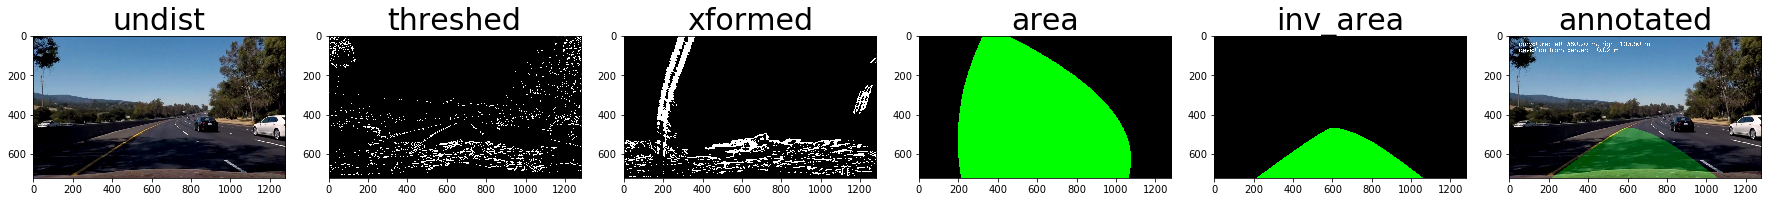

In [93]:
_ = annot.annotate_image(read_image('image3.jpg'), debug=True)

# Annotate Video

In [26]:
def save_image(img):
    bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite('output_images/image-%s.jpg'%(int(time.time())), bgr)
    return img
from moviepy.editor import VideoFileClip
from IPython.display import HTML
def save_clip(beg, end):
    output = 'annotated_project_video.mp4'
    input_clip = VideoFileClip('project_video.mp4').subclip(beg, end)
    clip = input_clip.fl_image(save_image)
    %time clip.write_videofile(output, audio=False)
    

In [94]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

annotate = AnnotateLane (camera, for_video=True)
output = 'annotated_project_video.mp4'
input_clip = VideoFileClip('project_video.mp4')
clip = input_clip.fl_image(annotate.annotate_image)

%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video annotated_project_video.mp4
[MoviePy] Writing video annotated_project_video.mp4


100%|█████████▉| 1260/1261 [06:26<00:00,  3.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: annotated_project_video.mp4 

CPU times: user 8min 38s, sys: 1min 28s, total: 10min 6s
Wall time: 6min 28s
